# [팀과제] Santa 이미지 vs 일반인 이미지 분류 하기

### 목표: VGG19 직접 구현 & 전이학습 성능 비교

본 과제는 CNN 구조 이해 → VGG19 아키텍처 구현 → 전이학습 적용을 통한 성능 개선의 전체 흐름을 경험하는 것을 목표로 합니다.

단순히 모델을 사용하는 것이 아니라, 직접 구현하고 ‘성능을 비교’ 및 분석하는 것이 핵심입니다.

1. VGG19 모델 직접 구현

    - VGG19 구조를 참고하여 직접 구현
        - Convolution Block (Conv + ReLU)
        - MaxPooling
        - Fully Connected Layer

    - Loss, Optimizer 는 자유 선

2. 요구사항

    - torchvision.models.vgg19() 를 직접 호출하지 말 것
    - 구조를 코드로 직접 작성할 것

3. 비교 필수

    - 직접 구현 VGG19 vs 전이 학습 VGG19
    - Accuracy, Loss, 학습 속도 비교

4. 필수 제출

- Colab Notebook 또는 .ipynb 파일을 깃허브에 배포
- 전체 실행 가능해야 함(학습 결과 그래프 캡처, 최종 Test Accuracy 스크린샷, 분석 정리 등 포함)


# **1. 라이브러리 import 및 폴더 생성**

### 처음부터 다시 실행 할 경우, 런타임 연결 해제 및 삭제 후 재실행.

### 이 때, 왼쪽의 파일창이 초기화 되어서, santa.zip과 Save_files가 모두 없어집니다.!!

- 필요시 백업 필수!

- 필요시, santa.zip을 개인 Data 폴더에 따로 저장하고, 경로복사해서 불러오기 권장.

In [1]:
# 1-1. 라이브러리 import 모음
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import os
import zipfile
import numpy as np

In [2]:
# [필요시 확인사항]
# 1. SymPy 버전 다운그레이드 관련 호환성 에러가 나오면...아래 !pip install "sympy<1.13" 를 실행할 것.
# 2. 설치가 완료되면, 상단 메뉴에서 [런타임] -> [세션 다시 시작]을 클릭하세요.
# 3. 그 후 다시 import 코드를 실행하면 에러가 사라집니다.

In [3]:
# !pip install "sympy<1.13"

In [4]:
# 1-0. GPU 설정
# 'cuda'가 출력되어야 GPU 가속을 받습니다.
# GPU로 계산해야 연산 시간을 크게 단축시킵니다.
# 런타임 -> 런타임 유형 변경 -> T4 GPU 이상 선택

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f">>> 현재 사용 중인 디바이스: {device}")

>>> 현재 사용 중인 디바이스: cuda


In [5]:
# 1-2. 사용 데이터 및 저장 폴더 생성하기
# Colab 왼쪽 파일 창 내에 생성됨
data_dir = './Data'
os.makedirs(data_dir, exist_ok=True)

save_dir = './Save_files'
os.makedirs(save_dir, exist_ok=True)

# 여기서 잠깐!!!

왼쪽 파일창에서 '새로고침'을 한 후,

- ## **생성된 Data 폴더에 santa.zip을 반드시 넣어주세요.**

왼쪽 파일창 하단에 santa.zip의 업로드가 완료될 때까지 기다려주세요.

- Save_files 폴더가 생성된 것을 추가로 확인하세요.

이곳에 비교 데이터들이 저장됩니다.

### **[확인사항] Data 자료(santa.zip)의 구성**

압축을 풀면, 왼쪽 파일 창에서 아래 사항 확인.

- Data 폴더 내에 train, val, test 3가지 각 폴더들로 나뉘고,
- 또한 각각 폴더들에 normal, santa 두가지 폴더로 나뉘어 이미지가 저장되어 있음.



normal 폴더에는 사람이 아닌 동물(고양이 등) 이미지도 포함되어 있음.

- train 폴더 내 :
    - \normal 폴더에 jpg 파일 449 개 , ex; 6.not-a-santa.jpg
    - \santa 폴더에 jpg 파일 446 개 , ex; 6.Santa.jpg

- val 폴더 내 :
    - \normal 폴더에 jpg 파일 134 개 , ex; 407.not-a-santa.jpg
    - \santa 폴더에 jpg 파일 133 개 , ex; 411.Santa.jpg

- test 폴더 내 :
    - \normal 폴더에 jpg 파일 32 개 , ex; 552.not-a-santa.jpg
    - \santa 폴더에 jpg 파일 36 개 , ex; 574.Santa.jpg


# **2. 데이터 준비 : 업로드 및 압축 해제**

In [6]:
# 데이터 폴더 준비
zip_path = './Data/santa.zip'
extract_path = './Data/'

# 폴더가 없으면 생성
if not os.path.exists('./Data'):
    os.makedirs('./Data')

# 2-1. 파일이 존재하는지 확인하고 없으면 업로드 요청 (Colab 전용)
if not os.path.exists(zip_path):
    print(">>> santa.zip 파일이 없습니다. 파일을 업로드해주세요.")
    from google.colab import files
    uploaded = files.upload()
    # 업로드된 파일을 Data 폴더로 이동 (파일명이 santa.zip이라고 가정)
    for filename in uploaded.keys():
        os.rename(filename, zip_path)

# 2-2. 압축 해제
if not os.path.exists(os.path.join(extract_path, 'train')):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(">>> 데이터 압축 해제 완료")
else:
    print(">>> 이미 데이터가 압축 해제되어 있습니다.")

>>> 데이터 압축 해제 완료


# **3. 데이터 전처리 및 로더 설정**

이미지를 모델이 이해할 수 있는 텐서(Tensor) 형태로 변환하고 정규화(Normalization)합니다.

In [7]:
# 3-1. 이미지 전처리 파이프라인 정의
# ImageNet 학습 시, 사용된 평균/표준편차로 정규화해야 전이학습 효과가 극대화 된다.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG19 입력 크기
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3-2. 데이터셋 연결
# ImageFolder는 폴더명(santa, normal)을 자동으로 라벨(0, 1)로 변환한다.
train_dataset = datasets.ImageFolder('./Data/train', transform=transform)
val_dataset = datasets.ImageFolder('./Data/val', transform=transform)
test_dataset = datasets.ImageFolder('./Data/test', transform=transform)

# 3. DataLoader 설정
# batch_size: 한 번에 학습할 이미지 수 (GPU 메모리에 따라 조절 가능)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True) # 시각화용 셔플

print(f">>> 데이터 준비 완료 | Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

>>> 데이터 준비 완료 | Train: 895, Val: 267, Test: 68


# **4. VGG Model class 정의 (Scratch vs Transfer)**

두 가지 모델의 구조를 정의합니다.

### **VGG19 Scratch Model (직접 구현):**

- Features (Conv. Layers): 무작위 값으로 초기화하여 처음부터 다시 학습합니다. (학습 O)

- Classifier (FC Layers): 무작위 값으로 초기화하여 처음부터 다시 학습합니다. (학습 O)


### **VGG19 Transfer Model (전이 학습):**

- Features (Conv. Layers): ImageNet 가중치를 그대로 가져와서 "고정(Freeze)"합니다. (학습 X)

- Classifier (FC Layers): 무작위 값으로 초기화하여 처음부터 다시 학습합니다. (학습 O)


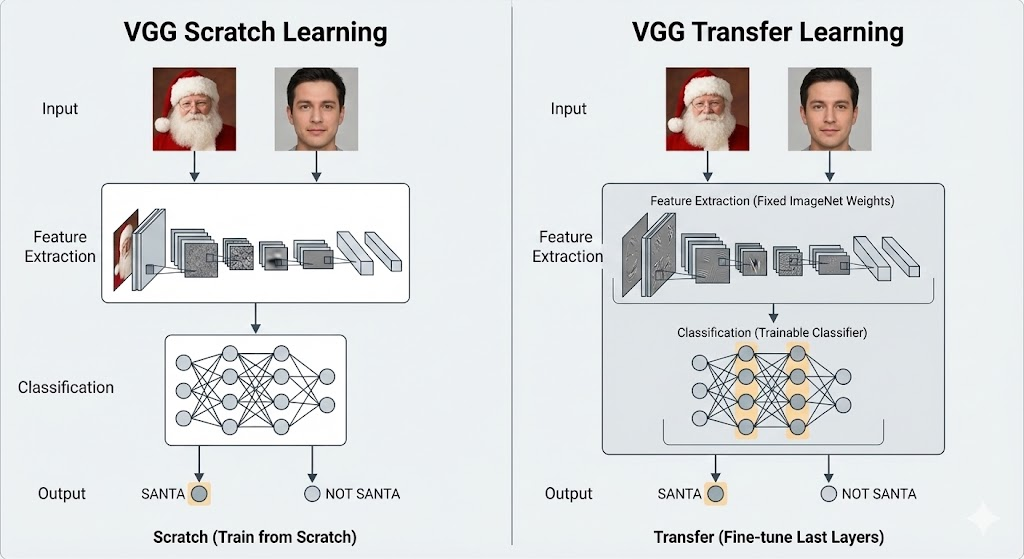

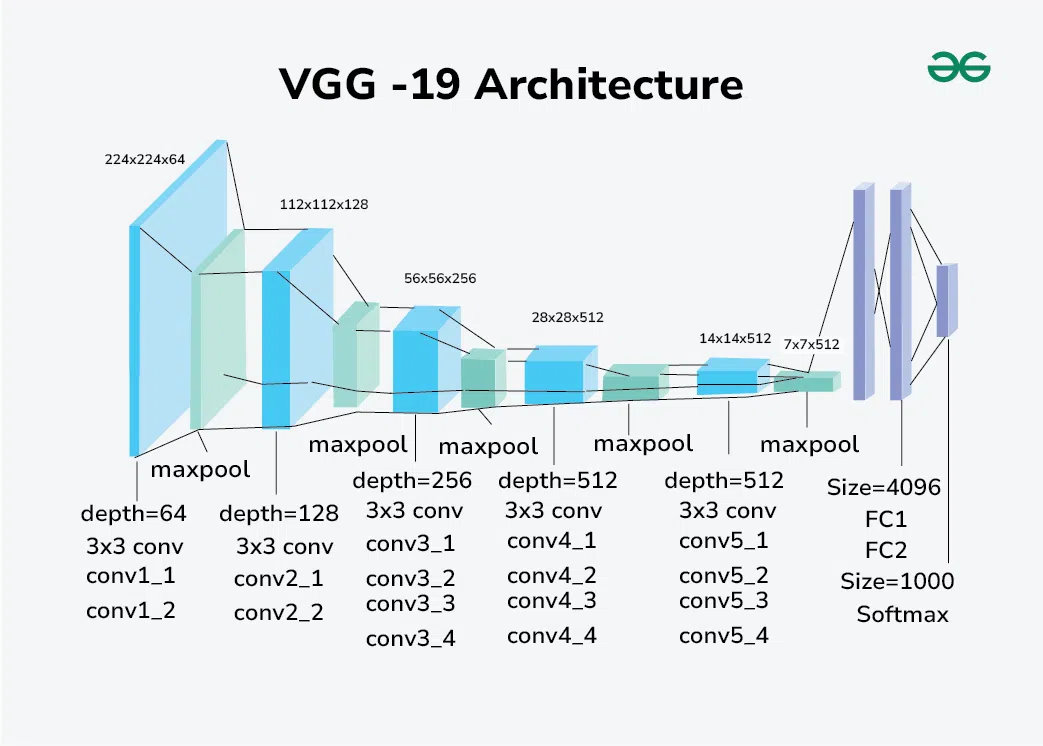

In [8]:
# 4. VGG Models (Scratch vs Transfer) 실행
#========================================================================
# [Model 1] Scratch VGG19 (직접 구현) -----------------------------------
# 특징: 모든 가중치가 무작위(Random) 상태에서 시작합니다.
class VGG19_Scratch(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19_Scratch, self).__init__()
        # VGG19의 레이어 구성 (숫자: 필터 수, 'M': 맥스풀링)
        self.cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M',
                    512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        self.features = self._make_layers(self.cfg)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x), # 학습 안정성을 위해 추가
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# [Model 2] Transfer VGG19 (전이 학습) --------------------------------------
# 특징: ImageNet 가중치를 가져와 Features를 동결(Freeze)합니다.
def get_transfer_model():
    # 1. ImageNet 가중치 로드
    model = models.vgg19(weights='IMAGENET1K_V1')

    # 2. 모든 파라미터 동결 (학습되지 않도록 설정)
    # 이렇게 하면 Features(conv)와 Classifier 앞부분이 고정됩니다.
    for param in model.parameters():
        param.requires_grad = False

    # 3. 마지막 출력층만 교체 (이 부분은 새로 생성되므로 requires_grad=True 상태)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 2)

    return model.to(device)

# **5. 학습 및 시각화 그래프 정의**

반복적으로 사용될 학습 logic과 결과 그래프 그리는 함수.

In [9]:
# 5-1. 학습 및 로그(logfile) 기록 함수
def train_and_log(model, model_name, criterion, optimizer, num_epochs):
    logs = []
    prev_acc = 0.0
    print(f"\n>>> {model_name} 모델 학습 시작 (Epochs: {num_epochs})")

    for epoch in range(num_epochs):
        start_time = time.time()

        # Train
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)

        val_acc = (correct.double() / len(val_loader.dataset)).item()
        epoch_time = time.time() - start_time

        # 수렴 속도(변화량) 계산
        acc_gradient = val_acc - prev_acc
        prev_acc = val_acc

        logs.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_acc': val_acc,
            'epoch_time': epoch_time,
            'acc_gradient': acc_gradient
        })

        if (epoch + 1) % 1 == 0: # 매 에폭마다 출력
            print(f"[{model_name}] Epoch {epoch+1:02d} | Loss: {train_loss:.4f} | Acc: {val_acc:.4f} | Time: {epoch_time:.2f}s")

    # 결과 CSV 파일 저장
    df = pd.DataFrame(logs)
    csv_path = os.path.join(save_dir, f'{model_name}_results_Epoch_{num_epochs}.csv')
    df.to_csv(csv_path, index=False)
    return df

In [10]:
# 5-2. 가중치 비교 저장 함수
def save_weight_comparison(model_s, model_t):
    # 첫 번째 Conv 레이어의 가중치를 추출하여 분포 비교
    weights_s = model_s.features[0].weight.data.cpu().numpy().flatten()
    weights_t = model_t.features[0].weight.data.cpu().numpy().flatten()

    df_weights = pd.DataFrame({
        'Scratch_Weights': weights_s,
        'Transfer_Weights': weights_t
    })
    csv_path = os.path.join(save_dir, f'weight_comparison_Epoch_{num_epochs}.csv')
    df_weights.to_csv(csv_path, index=False)
    return weights_s, weights_t

In [11]:
# 5-3. 결과 그래프(2x2) 시각화 함수
def plot_full_comparison(df_s, df_t, w_s, w_t):
    epochs = df_s['epoch']
    plt.figure(figsize=(15, 12))

    # 전체 중앙 제목 추가 (Epoch 정보 포함)
    plt.suptitle(f'Model Performance Comparison (Total Epochs: {num_epochs})', fontsize=20, fontweight='bold')

    # Loss
    ax1 = plt.subplot(2, 2, 1)
    plt.plot(epochs, df_s['train_loss'], 'o-', label='Scratch')
    plt.plot(epochs, df_t['train_loss'], 's-', label='Transfer')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    # Accuracy
    ax1 = plt.subplot(2, 2, 2)
    plt.plot(epochs, df_s['val_acc'], 'o-', label='Scratch')
    plt.plot(epochs, df_t['val_acc'], 's-', label='Transfer')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    # Weight Distribution
    ax1 = plt.subplot(2, 2, 3)
    plt.hist(w_t, bins=50, alpha=0.5, label='Transfer (ImageNet)', color='orange')
    plt.hist(w_s, bins=50, alpha=0.5, label='Scratch (Random)', color='blue')
    plt.title('First Layer Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Count')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    # Convergence Speed
    ax1 = plt.subplot(2, 2, 4)
    plt.bar(epochs - 0.2, df_s['acc_gradient'], width=0.4, label='Scratch')
    plt.bar(epochs + 0.2, df_t['acc_gradient'], width=0.4, label='Transfer')
    plt.title('Convergence Speed (Acc Delta)')
    plt.xlabel('Epoch')
    plt.ylabel('Acc Change')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(save_dir, f'Results_comparison_Epoch_{num_epochs}.png'))
    print(">>> 2x2 결과 그래프 저장 완료")

In [12]:
# 5-4. 예측 이미지 비교 시각화 함수 (santa vs normal)
def visualize_combined(model_s, model_t, loader):
    model_s.eval()
    model_t.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    out_s = model_s(images)
    _, preds_s = torch.max(out_s, 1)
    out_t = model_t(images)
    _, preds_t = torch.max(out_t, 1)
    classes = ['Normal', 'Santa']

    plt.figure(figsize=(16, 6))
    plt.suptitle(f'Compare Inference Results at Epoch {num_epochs}: Scratch(Top) vs Transfer(Bottom)', fontsize=18, fontweight='bold')

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(8):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Scratch
        ax1 = plt.subplot(2, 8, i+1)
        ax1.imshow(img)
        color = 'green' if preds_s[i] == labels[i] else 'red'
        ax1.set_title(f'Scratch\nP:{classes[preds_s[i]]}', color=color, fontsize=10)
        ax1.axis('off')

        # Transfer
        ax2 = plt.subplot(2, 8, i+9)
        ax2.imshow(img)
        color = 'green' if preds_t[i] == labels[i] else 'red'
        ax2.set_title(f'Transfer\nP:{classes[preds_t[i]]}', color=color, fontsize=10)
        ax2.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(save_dir, f'Images_comparison_Epoch_{num_epochs}.png'))
    print(">>> 예측 이미지 저장 완료")

# **6. 실행 (학습 및 결과 그래프 출력)**

이제 설정된 파라미터로 실제 학습을 진행합니다.

### Epochs : 20 인 경우

In [13]:
# 실행부(UI): Epoch 수 및 Hiperparameter 설정

# ==========================================
num_epochs = 20  # <= Epoch 수 결정
# ==========================================

criterion = nn.CrossEntropyLoss()

# 1. 모델 초기화
model_s = VGG19_Scratch().to(device)
model_t = get_transfer_model()

# 2. 학습 전 가중치 상태 저장 (초기화 상태 비교용)
w_s, w_t = save_weight_comparison(model_s, model_t)

# 3. Scratch 모델 학습 (Conv 필터부터 모든 것을 배움 - 느림, 어려움)
optimizer_s = optim.Adam(model_s.parameters(), lr=0.0001)
df_scratch = train_and_log(model_s, "Scratch", criterion, optimizer_s, num_epochs)

# 4. Transfer 모델 학습 (ImageNet 지식 활용 - 빠름, 정확함)
# model_t.classifier.parameters()를 넘겨주므로 분류기 부분만 업데이트 됩니다.
optimizer_t = optim.Adam(model_t.classifier.parameters(), lr=0.0001)
df_transfer = train_and_log(model_t, "Transfer", criterion, optimizer_t, num_epochs)

print("\n" + "="*40)
print("!!모든 모델 학습이 종료되었습니다.")
print("="*40 + "\n")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 237MB/s]



>>> Scratch 모델 학습 시작 (Epochs: 20)
[Scratch] Epoch 01 | Loss: 0.6077 | Acc: 0.5019 | Time: 18.57s
[Scratch] Epoch 02 | Loss: 0.3851 | Acc: 0.8689 | Time: 16.06s
[Scratch] Epoch 03 | Loss: 0.3950 | Acc: 0.9064 | Time: 15.91s
[Scratch] Epoch 04 | Loss: 0.3514 | Acc: 0.9101 | Time: 15.80s
[Scratch] Epoch 05 | Loss: 0.2471 | Acc: 0.9176 | Time: 15.83s
[Scratch] Epoch 06 | Loss: 0.2868 | Acc: 0.8914 | Time: 16.03s
[Scratch] Epoch 07 | Loss: 0.2539 | Acc: 0.8652 | Time: 15.96s
[Scratch] Epoch 08 | Loss: 0.2810 | Acc: 0.9139 | Time: 15.90s
[Scratch] Epoch 09 | Loss: 0.2211 | Acc: 0.9251 | Time: 16.10s
[Scratch] Epoch 10 | Loss: 0.1785 | Acc: 0.9363 | Time: 15.99s
[Scratch] Epoch 11 | Loss: 0.2024 | Acc: 0.8914 | Time: 15.94s
[Scratch] Epoch 12 | Loss: 0.2384 | Acc: 0.9026 | Time: 15.99s
[Scratch] Epoch 13 | Loss: 0.1850 | Acc: 0.9101 | Time: 15.92s
[Scratch] Epoch 14 | Loss: 0.1614 | Acc: 0.9363 | Time: 16.27s
[Scratch] Epoch 15 | Loss: 0.2363 | Acc: 0.9139 | Time: 16.04s
[Scratch] Epoch 16 |

>>> 2x2 결과 그래프 저장 완료


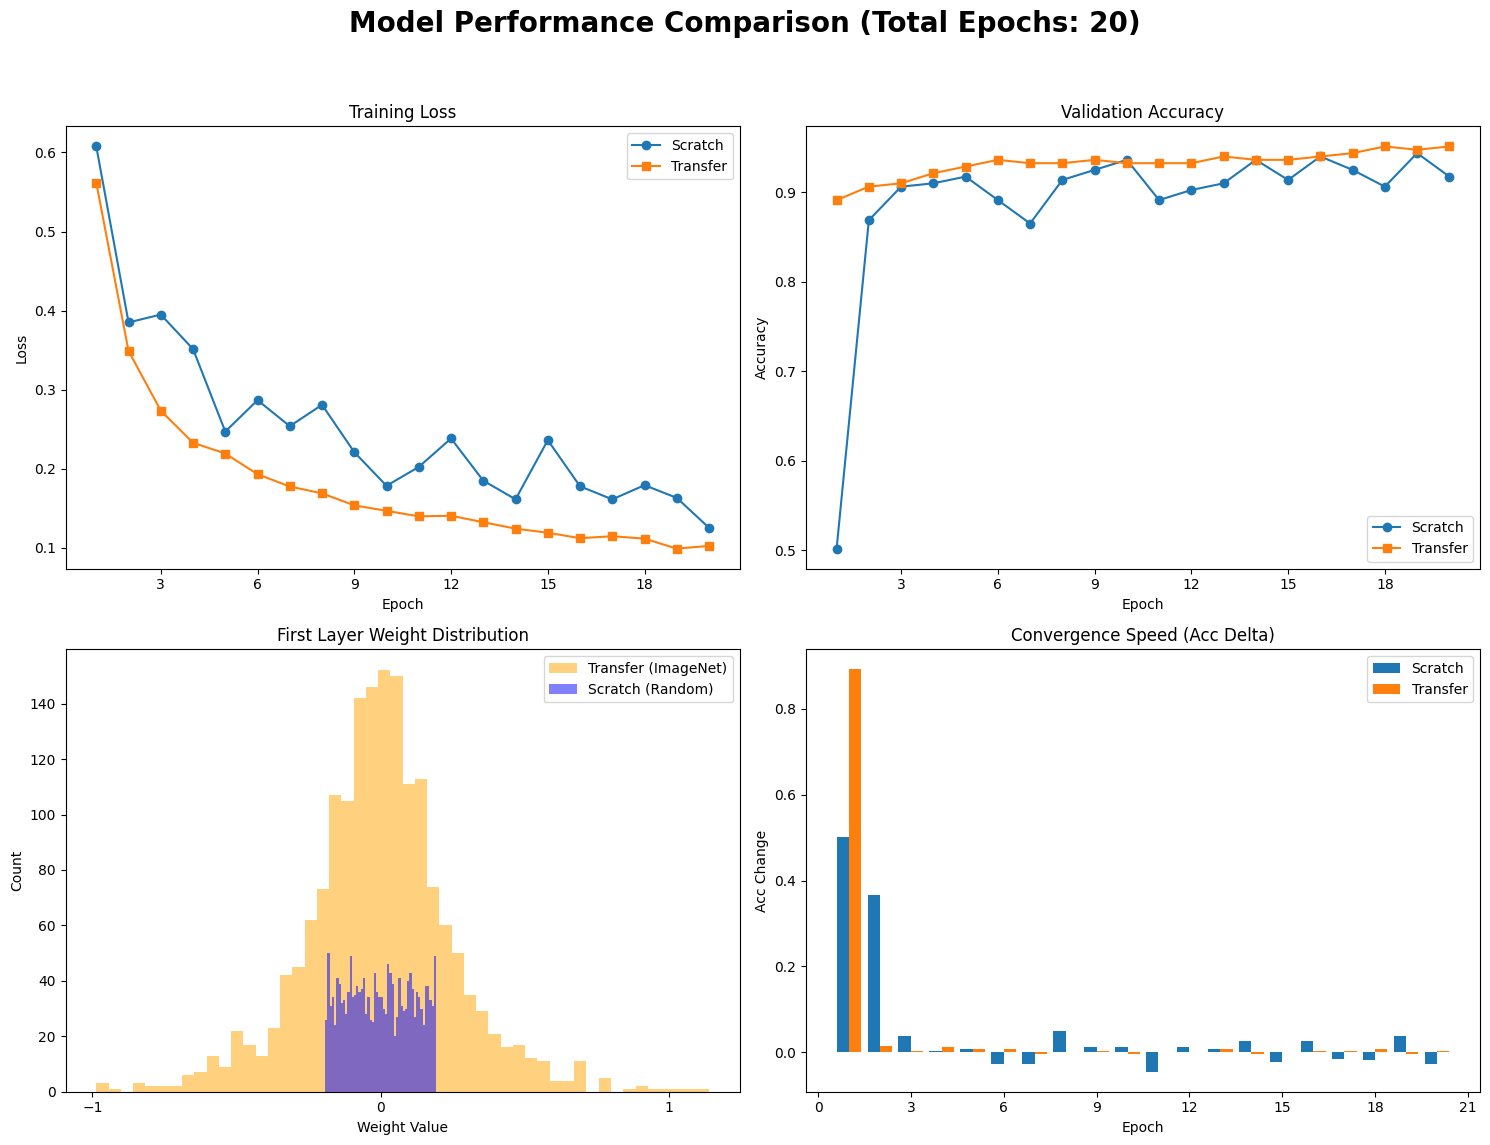

In [14]:
# 5. 결과 그래프 출력 (Colab에서는 plt.show()가 셀 안에 있어야 함)
plot_full_comparison(df_scratch, df_transfer, w_s, w_t)

>>> 예측 이미지 저장 완료


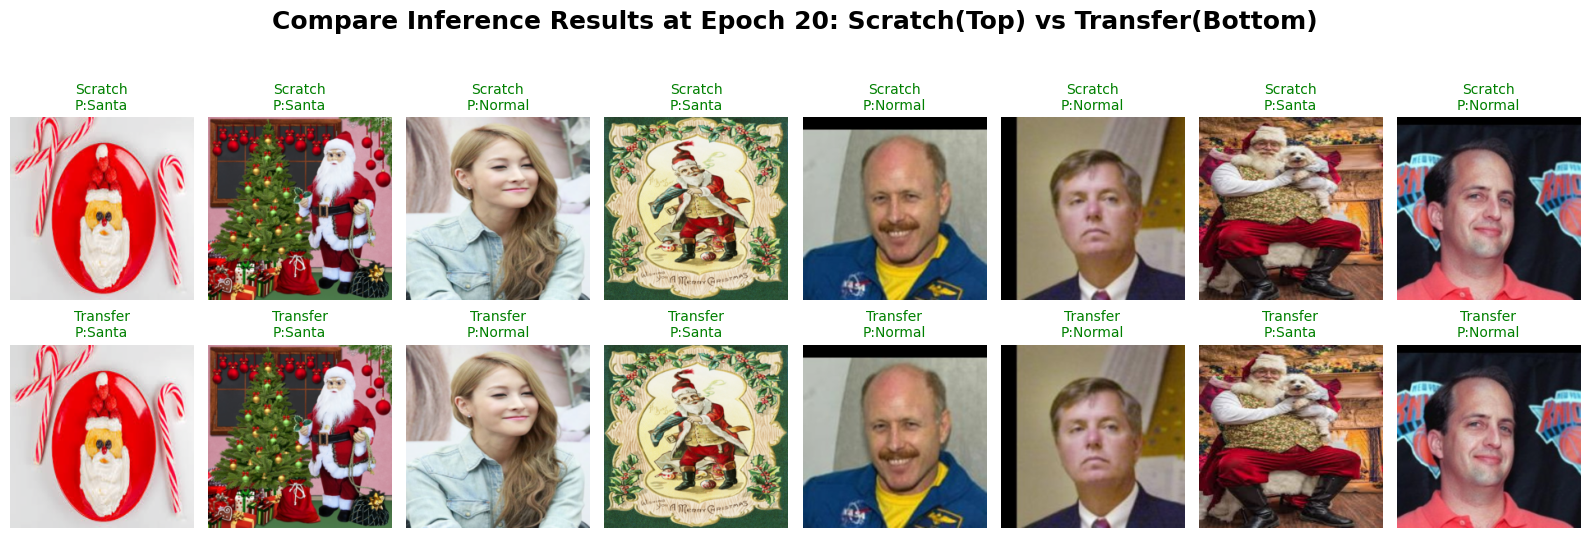

In [15]:
# 6. 이미지 비교-확인 그래프 출력
visualize_combined(model_s, model_t, test_loader)
plt.show()

# VGG19 Models: Scratch Learning vs. Transfer Learning 비교 결과

- 소규모 데이터셋(Santa vs Normal) 환경에서 모델을 처음부터 학습시키는 방식(Scratch learning; 직접학습)과 사전 학습된 지식을 활용하는 방식(Transfer learning; 전이학습)의 이미지 구분 성능을 비교했다.


## 주요 결과치 비교 (Epoch 20 기준)

이미지 비교 결과에도 전이 학습의 경우에는 santa와 normal을 모두 잘 맞춘 반면에, 직접 학습의 경우에는 이미지를 잘 못 판단한 경우를 간헐적으로 확인할 수 있다.

- Scratch 모델 (직접 학습)의 경우,
    - 최종 검증 정확도(val_acc) : 약 90 % (변동성 높음)
    - 최종 손실(Train_Loss) : 약 0.2
    - 수렴 시점 : 10 Epoch 이후에도 불안정

- Transfer 모델 (전이 학습)의 경우,
최종 검증 정확도 (val_acc)
    - Val_Acc : 약 95 % (안정적으로 유지됨)
    - Train_Loss : 약 0.1
    - 수렴 시점 : 5 Epoch 전후로 거의 수렴함.

# > 상세 결과 해석

## 1. 학습의 안정성과 과적합 (Stability & Overfitting)

- Scratch 모델(직접 학습):
    - 데이터 이미지 수(약 900장)가 모델의 깊이(19 layer)에 비해 매우 적기 때문에, 학습 곡선이 매끄럽지 못하고 Epoch마다 정확도가 줄어드는(포인트가 튀는 현상)이 나타난다. 이것은 직접 학습시키는 경우에 일반적인 특징을 배우기보다 특정 이미지에 과적합(Overfitting) 되는 경향을 보이기 때문이다.

- Transfer 모델(전이 학습):
    - 이미 ImageNet의 120만 장 데이터를 통해 '이미지를 보는 법'을 학습하여 매우 높은 신뢰성을 확보한 상태이므로, 매우 적은 오차 범위 내에서 안정적으로 학습을 마무리할 수 있다(보증됨).

## 2. 수렴 속도 분석 (Convergence Speed)

- acc_gradient 지표를 보면, Transfer 모델은 Epoch 1~2에서 폭발적인 성능 향상을 보인 뒤 지표가 0에 가까워진다(수렴함). 이것은 이미 잘 학습된 Feature Extraction를 기반으로 classification에서 santa image의 특징만 빠르게 학습했음을 의미한다.

- 반면 Scratch 모델은 Epoch 10이 넘어서도 가중치를 미세 조정하며 성능을 끌어 올리려고 하지만, 전이 학습의 초기 성능에 근접하는 것도 버거운 상태이다.


## 3. 가중치 분포의 의미 (Weight Distribution)

- weight_comparison.csv 데이터에서 나타나듯, Scratch 모델은 초기 무작위(Random) 상태에서 크게 벗어나지 못한 좁은 가중치 분포를 가진다.

- 반면 Transfer 모델은 ImageNet에서 학습된 다양한 필터(선, 면, 질감 인식)들에 의한 학습 결과로 가중치 분포가 훨씬 넓고 정규분포에 가깝다. 따라서 '이미 준비된 필터'들이 산타 이미지의 특징(수염, 빨간 옷, 빨간 모자 등)을 매우 잘 포착할 수 있다.


## 4. 요약

- 현재의 소규모의 데이터셋에서는 VGG19을 직접 학습(Scratch)시키는 것보다 전이 학습(Transfer)을 사용하는 것이 훨씬 효율적이고 높은 신뢰도(정답률)을 보증한다고 할 수 있다.
    



# **A-3. 데이터 증강을 적용한 전처리 및 로더 추가 설정**

- VGG19의 특성:

    - VGG19 모델은 약 1억 4천만 개(144M)의 파라미터를 가진 매우 거대한 모델입니다. 이런 거대한 신경망을 '바닥부터(Scratch)' 학습시켜 제 성능을 내려면 일반적으로 수십만 장 이상의 데이터가 권장됩니다. (VGG가 원래 학습된 ImageNet 데이터셋은 약 120만 장입니다.)

- 현재 산타 이미지 900장의 한계:

    - 현재의 900장은 모델의 복잡도에 비해 턱없이 부족하여, 필연적으로 과적합(Overfitting)이 발생할 수밖에 없는 구조입니다.

### **Data Augmentation(데이터 증강) 로직 추가하기**

- 현재의 부족한 데이터(900장) 한계를 극복하기 위해, 이미지를 회전하거나 자르는 등의 변화를 주어 데이터를 소위'뻥튀기'하는 데이터 증강(Data Augmentation) 방법을 적용하여 결과의 개선 여부를 판단하고자 합니다.

- 핵심 변경 사항:

    - 학습용(train_transform): 이미지를 무작위로 자르고, 뒤집고, 회전시켜 모델이 매번 조금씩 다른 이미지를 보게 만듭니다. (난이도 상승 -> 학습 효과 증대)

    - 검증/테스트용(test_transform): 정해진 크기로만 깔끔하게 변환하여 공정한 평가를 진행합니다.


### **증강 효과의 물리적 이미지 개수 산출**

- 결론 : 물리적인 파일 개수는 그대로 900장이지만, 학습 관점에서는 '무한대'와 다름 없는 매우 큰 데이터를 확보한 효과입니다. 즉, 이번 20 Epoch 학습을 통해 모델은 약 18,000장의 다양한 산타 이미지를 공부한 것과 같은 경험치를 얻게 됩니다.

1. 물리적 개수 vs. 학습 데이터 개수

- 하드디스크 파일 수: 여전히 900장입니다. (파일을 복사해서 늘리는 것이 아닙니다.)

- 모델이 보는 이미지 수: 학습할 때마다(매 Epoch마다) 코드가 이미지를 실시간으로 변형해서 던져줍니다.

    - Epoch: 900장의 서로 다른 변형된 이미지 학습20
    - Epoch: 900 x 20 = 18,000장의 서로 다른 이미지 학습 효과

2. '무한대'와 다름 없는 효과인 이유?

- RandomRotation, RandomResizedCrop 등은 소수점 단위로 미세하게 변합니다.

    - 첫 번째 Epoch에서는 13.5도 회전된 산타를 보고,
    - 두 번째 Epoch에서는 5.2도 회전되고 약간 확대된 산타를 봅니다.

이 조합의 경우의 수가 사실상 무한하기 때문에, 모델은 매번 새로운 산타 이미지를 보는 것과 다름없습니다.

이것이 900장의 적은 데이터로도 VGG19 같은 거대 모델을 과적합 없이(Overfitting) 학습시킬 수 있는 핵심 원리입니다.



In [16]:
# ==========================================
# [수정됨] 데이터 전처리 및 증강 (Data Augmentation)
# ==========================================

# 3-1. 학습용 변환 (Train Transform): 데이터 증강 적용
# -> 이미지를 무작위로 변형하여 데이터 다양성 확보
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # 224x224로 무작위 크롭 (원본의 80~100% 크기 사용)
    transforms.RandomHorizontalFlip(p=0.5),              # 50% 확률로 좌우 반전
    transforms.RandomRotation(degrees=15),               # -15~15도 사이로 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 밝기 및 대비를 약간 변화시킴 (조명 변화 대응)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화
])

# 3-2. 검증 및 테스트용 변환 (Val/Test Transform): 증강 없음
# -> 평가 시에는 이미지를 변형하지 않고 정직하게 입력
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # 단순히 크기만 224x224로 맞춤
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==========================================
# 데이터셋 로드 (transform 적용 변경)
# ==========================================
# 학습 데이터셋에는 'train_transform' 적용
train_dataset = datasets.ImageFolder('./Data/train', transform=train_transform)

# 검증 및 테스트 데이터셋에는 'test_transform' 적용
val_dataset = datasets.ImageFolder('./Data/val', transform=test_transform)
test_dataset = datasets.ImageFolder('./Data/test', transform=test_transform)

# DataLoader 설정 (기존과 동일)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

print(">>> Data Augmentation이 적용된 데이터 로더가 준비되었습니다.")

>>> Data Augmentation이 적용된 데이터 로더가 준비되었습니다.


In [17]:
# 4. VGG Models (Scratch vs Transfer) 실행
#========================================================================
# [Model 1] Scratch VGG19 (직접 구현) -----------------------------------
# 특징: 모든 가중치가 무작위(Random) 상태에서 시작합니다.
class VGG19_Scratch(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19_Scratch, self).__init__()
        # VGG19의 레이어 구성 (숫자: 필터 수, 'M': 맥스풀링)
        self.cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M',
                    512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        self.features = self._make_layers(self.cfg)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x), # 학습 안정성을 위해 추가
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# [Model 2] Transfer VGG19 (전이 학습) --------------------------------------
# 특징: ImageNet 가중치를 가져와 Features를 동결(Freeze)합니다.
def get_transfer_model():
    # 1. ImageNet 가중치 로드
    model = models.vgg19(weights='IMAGENET1K_V1')

    # 2. 모든 파라미터 동결 (학습되지 않도록 설정)
    # 이렇게 하면 Features(conv)와 Classifier 앞부분이 고정됩니다.
    for param in model.parameters():
        param.requires_grad = False

    # 3. 마지막 출력층만 교체 (이 부분은 새로 생성되므로 requires_grad=True 상태)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 2)

    return model.to(device)

In [18]:
# 5-1. 학습 및 로그(logfile) 기록 함수
def train_and_log(model, model_name, criterion, optimizer, num_epochs, augmented=False):
    logs = []
    prev_acc = 0.0
    print(f"\n>>> {model_name} 모델 학습 시작 (Epochs: {num_epochs})")

    for epoch in range(num_epochs):
        start_time = time.time()

        # Train
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)

        val_acc = (correct.double() / len(val_loader.dataset)).item()
        epoch_time = time.time() - start_time

        # 수렴 속도(변화량) 계산
        acc_gradient = val_acc - prev_acc
        prev_acc = val_acc

        logs.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_acc': val_acc,
            'epoch_time': epoch_time,
            'acc_gradient': acc_gradient
        })

        if (epoch + 1) % 1 == 0: # 매 에폭마다 출력
            print(f"[{model_name}] Epoch {epoch+1:02d} | Loss: {train_loss:.4f} | Acc: {val_acc:.4f} | Time: {epoch_time:.2f}s")

    # 결과 CSV 파일 저장
    df = pd.DataFrame(logs)

    # 증강 여부에 따라 파일명 접미사 결정
    aug_suffix = "_Augmented" if augmented else ""

    csv_filename = f'{model_name}_results_Epoch_{num_epochs}{aug_suffix}.csv'
    csv_path = os.path.join(save_dir, csv_filename)
    df.to_csv(csv_path, index=False)
    return df

In [19]:
# 5-2. 가중치 비교 저장 함수
def save_weight_comparison(model_s, model_t, num_epochs, augmented=False):
    # 첫 번째 Conv 레이어의 가중치를 추출하여 분포 비교
    weights_s = model_s.features[0].weight.data.cpu().numpy().flatten()
    weights_t = model_t.features[0].weight.data.cpu().numpy().flatten()

    df_weights = pd.DataFrame({
        'Scratch_Weights': weights_s,
        'Transfer_Weights': weights_t
    })

    aug_suffix = "_Augmented" if augmented else ""
    csv_filename = f'weight_comparison_Epoch_{num_epochs}{aug_suffix}.csv'

    csv_path = os.path.join(save_dir, csv_filename)
    df_weights.to_csv(csv_path, index=False)
    return weights_s, weights_t

In [20]:
# 5-3. 결과 그래프(2x2) 시각화 함수
def plot_full_comparison(df_s, df_t, w_s, w_t, num_epochs, augmented=False):
    epochs = df_s['epoch']
    plt.figure(figsize=(15, 12))

    # 증강 여부에 따른 제목 및 파일명 접미사 설정
    aug_title = " (with Data Augmentation)" if augmented else ""
    aug_file = "_Augmented" if augmented else ""

   # 전체 제목에 증강 여부 표시
    plt.suptitle(f'Model Performance Comparison (Total Epochs: {num_epochs}){aug_title}', fontsize=20, fontweight='bold')
    # Loss
    ax1 = plt.subplot(2, 2, 1)
    plt.plot(epochs, df_s['train_loss'], 'o-', label='Scratch')
    plt.plot(epochs, df_t['train_loss'], 's-', label='Transfer')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    # Accuracy
    ax1 = plt.subplot(2, 2, 2)
    plt.plot(epochs, df_s['val_acc'], 'o-', label='Scratch')
    plt.plot(epochs, df_t['val_acc'], 's-', label='Transfer')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    # Weight Distribution
    ax1 = plt.subplot(2, 2, 3)
    plt.hist(w_t, bins=50, alpha=0.5, label='Transfer (ImageNet)', color='orange')
    plt.hist(w_s, bins=50, alpha=0.5, label='Scratch (Random)', color='blue')
    plt.title('First Layer Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Count')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    # Convergence Speed
    ax1 = plt.subplot(2, 2, 4)
    plt.bar(epochs - 0.2, df_s['acc_gradient'], width=0.4, label='Scratch')
    plt.bar(epochs + 0.2, df_t['acc_gradient'], width=0.4, label='Transfer')
    plt.title('Convergence Speed (Acc Delta)')
    plt.xlabel('Epoch')
    plt.ylabel('Acc Change')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = os.path.join(save_dir, f'Results_comparison_Epoch_{num_epochs}{aug_file}.png')
    plt.savefig(save_path)
    print(f">>> 2x2 결과 그래프 저장 완료: {save_path}")

In [21]:
# 5-4. 예측 이미지 비교 시각화 함수 (santa vs normal)
def visualize_combined(model_s, model_t, loader, num_epochs, augmented=False):
    model_s.eval()
    model_t.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    out_s = model_s(images)
    _, preds_s = torch.max(out_s, 1)
    out_t = model_t(images)
    _, preds_t = torch.max(out_t, 1)
    classes = ['Normal', 'Santa']

    # 증강 여부에 따른 제목 및 파일명 설정
    aug_title = " (with Data Augmentation)" if augmented else ""
    aug_file = "_Augmented" if augmented else ""

    plt.figure(figsize=(16, 6))
    plt.suptitle(f'Compare Inference Results at Epoch {num_epochs}){aug_title}: Scratch(Top) vs Transfer(Bottom)', fontsize=18, fontweight='bold')

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(8):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Scratch
        ax1 = plt.subplot(2, 8, i+1)
        ax1.imshow(img)
        color = 'green' if preds_s[i] == labels[i] else 'red'
        ax1.set_title(f'Scratch\nP:{classes[preds_s[i]]}', color=color, fontsize=10)
        ax1.axis('off')

        if i == 0: ax1.text(-0.0, 0.5, 'Scratch\n(Random)', transform=ax1.transAxes,
                            rotation=90, va='center', ha='right', fontsize=12, fontweight='bold')

        # Transfer
        ax2 = plt.subplot(2, 8, i+9)
        ax2.imshow(img)
        color = 'green' if preds_t[i] == labels[i] else 'red'
        ax2.set_title(f'Transfer\nP:{classes[preds_t[i]]}', color=color, fontsize=10)
        ax2.axis('off')

        if i == 0: ax2.text(-0.0, 0.5, 'Transfer\n(ImageNet)', transform=ax2.transAxes,
                            rotation=90, va='center', ha='right', fontsize=12, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = os.path.join(save_dir, f'Images_comparison_Epoch_{num_epochs}{aug_file}.png')
    plt.savefig(save_path)
    print(f">>> 예측 결과 이미지 저장 완료: {save_path}")

In [22]:
# 실행부(UI): Epoch 수 및 Hiperparameter 설정

if __name__ == "__main__":
    # 1. 설정
    # ==========================================
    num_epochs = 20  # <= Epoch 수 결정
    # ==========================================

    use_augmentation = True  # [중요] 증강 사용 시 True로 설정
    criterion = nn.CrossEntropyLoss()

    # 2. 모델 초기화
    model_s = VGG19_Scratch().to(device)
    model_t = get_transfer_model()

    # [수정됨] 가중치 저장 함수 호출 (augmented 인자 추가)
    w_s, w_t = save_weight_comparison(model_s, model_t, num_epochs, augmented=use_augmentation)

    # 3. Scratch 모델 학습
    optimizer_s = optim.Adam(model_s.parameters(), lr=0.0001)
    # [수정됨] 학습 함수 호출 (augmented 인자 추가)
    df_scratch = train_and_log(model_s, "Scratch", criterion, optimizer_s, num_epochs, augmented=use_augmentation)

    # 4. Transfer 모델 학습
    optimizer_t = optim.Adam(model_t.classifier.parameters(), lr=0.0001)
    # [수정됨] 학습 함수 호출 (augmented 인자 추가)
    df_transfer = train_and_log(model_t, "Transfer", criterion, optimizer_t, num_epochs, augmented=use_augmentation)

    # ---------------------------------------------------------
    print("\n" + "="*40)
    print(f"      모든 모델 학습이 종료되었습니다. (Total Epochs: {num_epochs})")
    print("="*40 + "\n")
    # ---------------------------------------------------------



>>> Scratch 모델 학습 시작 (Epochs: 20)
[Scratch] Epoch 01 | Loss: 0.7441 | Acc: 0.5918 | Time: 17.88s
[Scratch] Epoch 02 | Loss: 0.4083 | Acc: 0.9026 | Time: 17.87s
[Scratch] Epoch 03 | Loss: 0.3558 | Acc: 0.8951 | Time: 17.71s
[Scratch] Epoch 04 | Loss: 0.4488 | Acc: 0.8876 | Time: 17.82s
[Scratch] Epoch 05 | Loss: 0.3838 | Acc: 0.8876 | Time: 17.73s
[Scratch] Epoch 06 | Loss: 0.4153 | Acc: 0.9139 | Time: 17.98s
[Scratch] Epoch 07 | Loss: 0.3334 | Acc: 0.9064 | Time: 17.72s
[Scratch] Epoch 08 | Loss: 0.2814 | Acc: 0.8876 | Time: 17.82s
[Scratch] Epoch 09 | Loss: 0.2998 | Acc: 0.8989 | Time: 17.76s
[Scratch] Epoch 10 | Loss: 0.2520 | Acc: 0.9101 | Time: 17.95s
[Scratch] Epoch 11 | Loss: 0.2632 | Acc: 0.9326 | Time: 17.73s
[Scratch] Epoch 12 | Loss: 0.2640 | Acc: 0.9288 | Time: 17.68s
[Scratch] Epoch 13 | Loss: 0.2366 | Acc: 0.9101 | Time: 17.83s
[Scratch] Epoch 14 | Loss: 0.2361 | Acc: 0.9326 | Time: 17.97s
[Scratch] Epoch 15 | Loss: 0.2736 | Acc: 0.8727 | Time: 17.82s
[Scratch] Epoch 16 |

>>> 2x2 결과 그래프 저장 완료: ./Save_files/Results_comparison_Epoch_20_Augmented.png


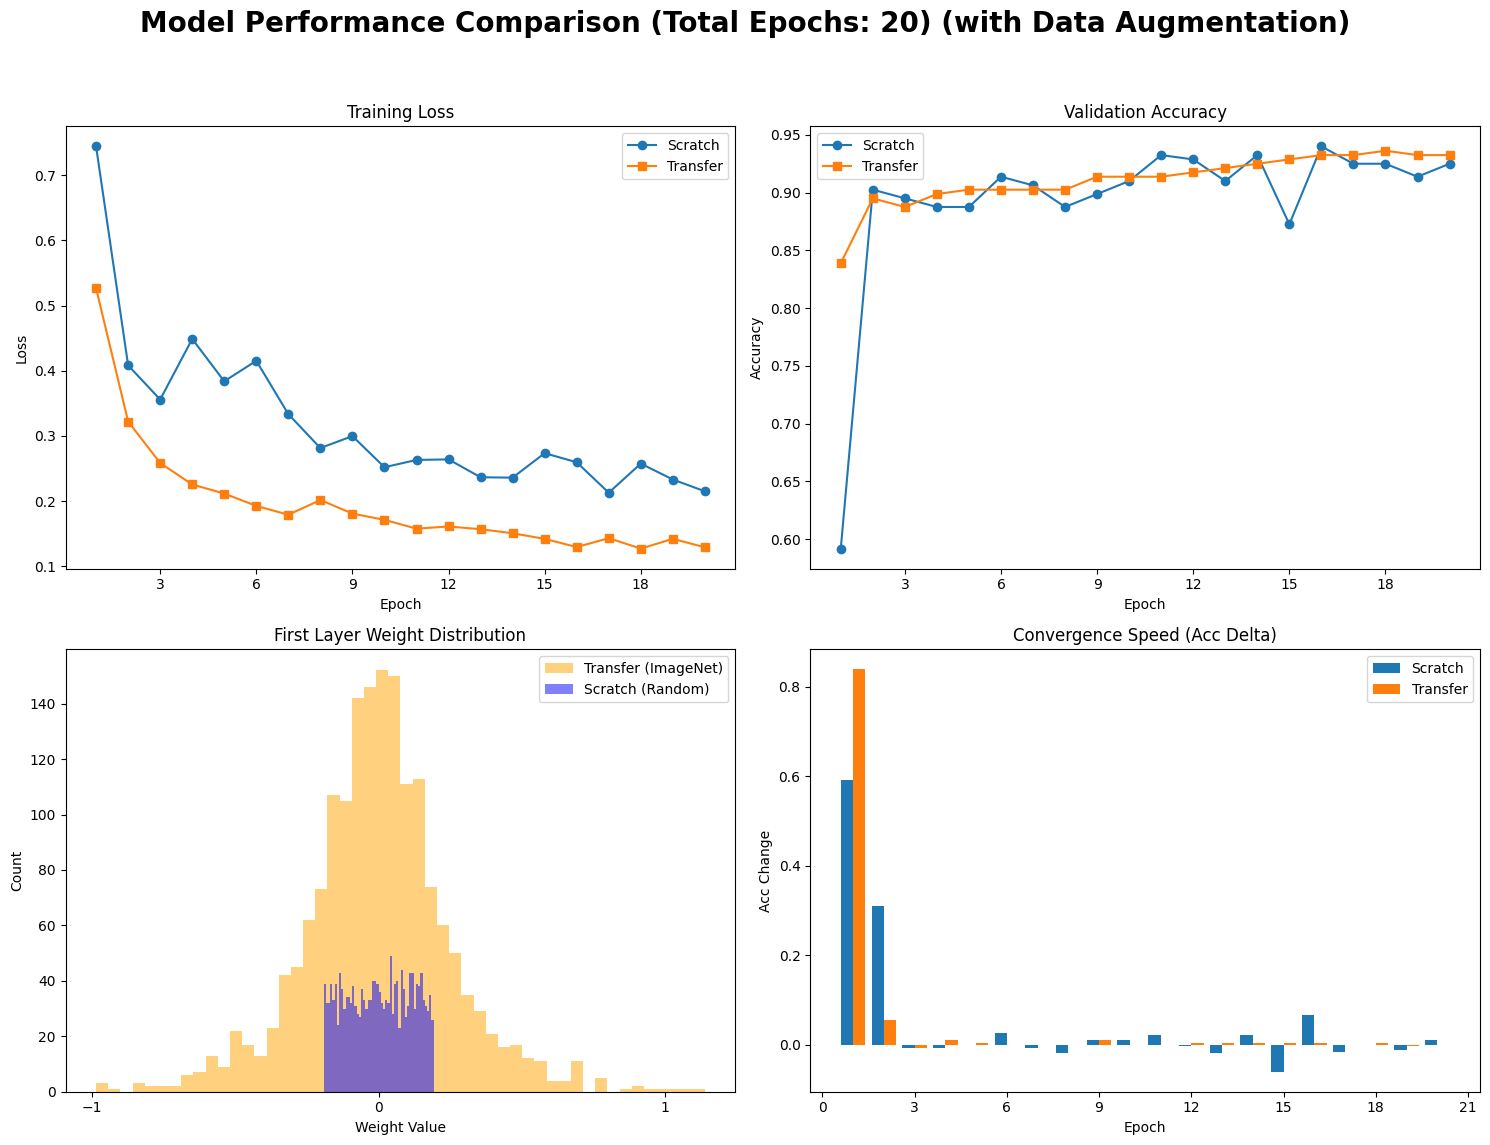

In [23]:
# 5. 결과 시각화 (제목에 with Data Augmentation 표시됨)
plot_full_comparison(df_scratch, df_transfer, w_s, w_t, num_epochs, augmented=use_augmentation)

>>> 예측 결과 이미지 저장 완료: ./Save_files/Images_comparison_Epoch_20_Augmented.png


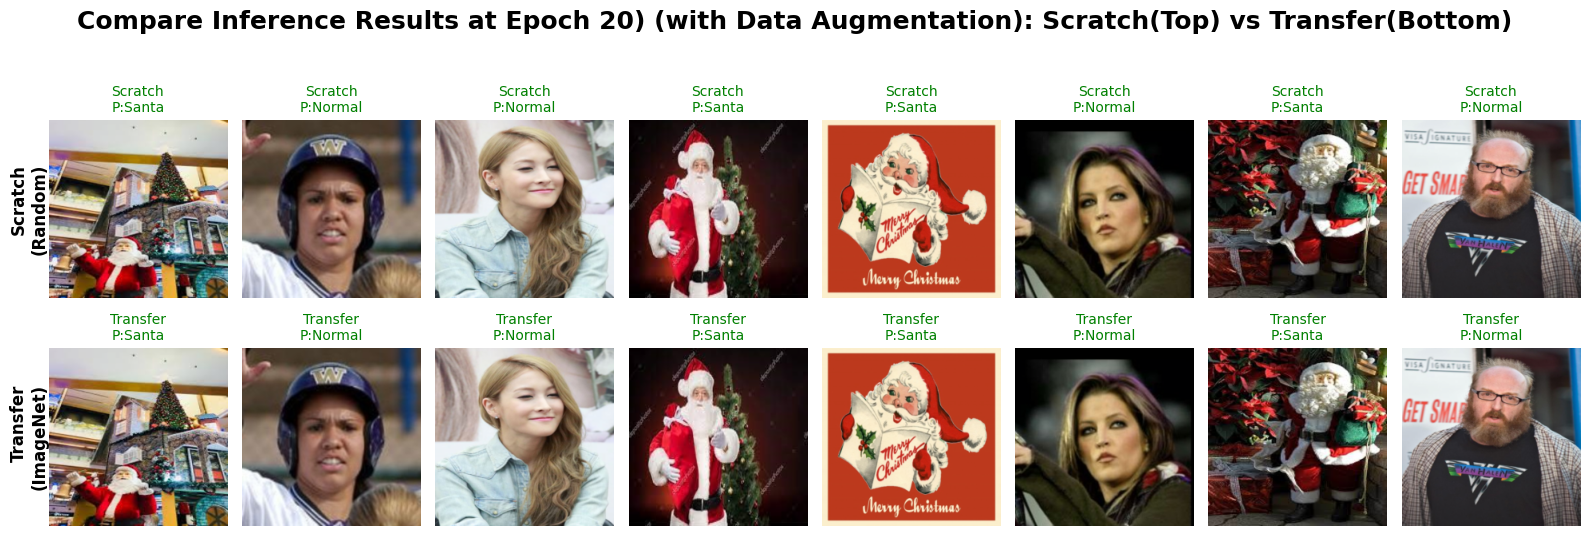

In [24]:
# 6. 예측 결과 시각화
visualize_combined(model_s, model_t, test_loader, num_epochs, augmented=use_augmentation)

plt.show()

## [Reminder]

# 증강 전 (Befroe the Data Augmentation)

### **이미지 증강을 적용하기 '전' 상황의 결과에 대한 분석 요약.**

### 1. Scratch 모델 (직접 학습)

* **상태:**
  * 불필요한 과적합 (Overfitting)

* **분석:**
  * 산타 이미지 '900장의 적은 데이터'로는 VGG19의 방대한 파라미터를 학습시키기에 매우 부족하다.
  * 정확도의 편차가 커서(롤러코스터 처럼) 학습이 매우 불안정하다.
  * 낮은 Loss(~0.12) 값에 비해 검증 성능 값이 급격히 변하는 것(튀는 상황)은, Scratch 모델이 산타의 특징을 제대로 학습한 것이 아니라, 불필요한 노이즈까지 과도하게 학습한 것으로 추론할 수 있다.

### 2. Transfer 모델 (전이 학습)

* **상태:**
  * 보증된 고성능 (High Performance)

* **분석:**
  * ImageNet 120만 장으로 학습된 가중치 덕분에, 학습 첫 Epoch부터 ~89% 이상의 높은 정확도(신뢰도)를 보인다.
  * 데이터 양과 관계없이 이미 보증된 결과 출력이 가능하여, 빠르고 안정적으로 수렴이 가능하다.

### 3. 요약
  * 적은 수의 데이터의 경우, 데이터 증강(Data Augmentation) 없이는 Scratch 모델이 Transfer 모델의 사전에 학습된 고성능을 극복하는 것이 불가능하다.

# 증강 후 (After the Data Augmentation)

### **이미지를 증강한 '후' 상황의 결과에 대한 분석 요약.**

### 1. Scratch 모델 (직접 학습)

* **상태:**
  * 개선된 학습, 일반화 지향 (Generalization)

* **분석:**
  * 900장의 이미지가 증강을 통해 약 18,000장의 경우와 같은 효과를 발휘하게 되면서, 데이터 부족 문제를 극복할 수 있다.
  * 불안정했던 정확도 값이 안정적인 우상향 곡선(~91.7%)으로 개선되었다.
  * 학습 Loss가 증가(0.12 -> 0.21)한 것은, 불필요한 학습(노이즈)을 최소화 하고, 산타 특징을 더 민감하게 학습한 것을 의미한다.

### 2. Transfer 모델 (전이 학습)

* **상태:**
  * 보증된 고성능의 재확인, 견고성 입증 (Robustness)"

* **분석:**
  * 증강된 (회전, 찌그러짐 등) 이미지들이 입력되었음에도 ~94% 정도의 최상위 성능을 잘 유지했다.
  * 이러한 안정적인 정확도의 결과는 Transfer 모델이 단순한 이미지 매칭을 넘어서, 보다 다양한 변수에도 올바른 결과를 출력할 수 있는 잘 학습된 성능을 증명한 의미로 해석할 수 있다.

### 3. 요약

  * 데이터 증강 방법은 Scratch 모델의 과적합 문제와 데이터 부족 문제를 상당히 개선할 수 있을 뿐만 아니라 전이 학습(Transfer) 모델과의 성능 격차를 크게 좁힐 수 있다.

# VGG19 Models (Scratch vs Transfer)에 대한,
# 최종 비교 분석 및 결론

- 데이터 증강은 단순한 기술적 기교가 아니라, "소규모 데이터셋이 가진 물리적 한계를 극복하고 모델의 학습의 성능을 극대화하고 결과의 신뢰성과 일반화를 최대한 보증하기 위한 핵심 방식 중 하나"이다.

#### 증강 전 vs 후 결과 비교

| 비교 항목 | 1. 증강 전 | 2. 증강 후 | 개선 후 분석 및 결론 |
| :--- | :--- | :--- | :--- |
| **Scratch 모델**<br>(직접 학습) | **불안정한 학습, 과적합 문제**<br>불필요한 값까지 학습하여 정확도가 떨어짐 | **보증된 고성능 및 일반화 가능**<br>증강된 이미지를 학습하여 문제점을 개선함 | **데이터 한계 극복, 성능 극대화 가능**<br>추가 데이터 없이도, 학습 로직에 안정성 확보 |
| **Transfer 모델**<br>(전이 학습) | **빠른 수렴 가능**<br>ImageNet 가중치를 기반으로 빠른 분석 가능 | **고성능 학습, 신뢰성 유지**<br>어려운 변형 문제도 ~94% 이상으로 해결함 | **보증된 실전 성능 재입증"**<br>현실적 환경에 대한 대응력 성능 재확인 |
| **Training Loss**<br>(학습 오차) | **매우 낮은 Loss(~0.12)**<br>불필요한 학습과 과적합된 결과 | **다소 높음 Loss (~0.21)**<br>문제점을 개선하여 학습 성능을 극대화 성공 | **최적 Loss 값의 역설**<br>최저 Loss가 반드시 최고 결과가 아님을 확인 |
| **모델 우위 여부** | **Transfer 모델 압승**<br>Scratch 모델의 문제가 간헐적으로 확인됨 | **Transfer 우세, Scratch 선전**<br>일반화 성능을 높인 Scratch 모델의 신뢰성 증가 | **성능 격차 해소**<br>증강 방법으로 직접 학습 모델의 성능 발휘 가능|

---
